In [1]:
import numpy as np
import math

In [2]:
filepath = '/home/ec2-user/SageMaker/efs/CS246/ratings.train.txt'

In [121]:
# params
k_num_eigenvectors = 20
lambda_regularization = 0.1
num_epochs = 40

In [122]:
def get_sets():
    users = set()
    items = set()
    # https://stackabuse.com/read-a-file-line-by-line-in-python/
    with open(filepath) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            ### EXTRACT
            line_whole = line.strip()
            line_values = line_whole.split("\t")
            line_user = int(line_values[0])
            line_item = int(line_values[1])
            line_rating = int(line_values[2])
            # print(user, item, rating)
            ### ADD
            users.add(line_user)
            items.add(line_item)
            # NEXT
            line = fp.readline()
            cnt += 1    
    return items, users

In [123]:
np.random.seed(0)

def init():
    U, I = get_sets()
    m = max(I)
    n = max(U)
    print("max(items)=", m, "max(users)=", n)
    # initialize
    min_value = 0
    max_value = math.sqrt(5/k_num_eigenvectors)
    # item-concept
    Q = np.random.random((m, k_num_eigenvectors)) * max_value
    # user-concept
    P = np.random.random((n, k_num_eigenvectors)) * max_value

    print(Q.shape, P.T.shape)
    return Q, P

q, p = init()


max(items)= 943 max(users)= 1682
(943, 20) (20, 1682)


In [124]:
np.linalg.norm(q)

39.41066134544589

In [125]:
np.linalg.norm(p)

52.935014591038104

In [126]:
def calc_loss(Q, P, lambda_regularization):
    
    loss = 0

    # loss += (R - Q[i] @ P[u].T) ** 2
    with open(filepath) as fp:
        line = fp.readline()
        while line:
            ### EXTRACT
            line_whole = line.strip()
            line_values = line_whole.split("\t")
            line_item = int(line_values[0])
            line_user = int(line_values[1])
            Riu = int(line_values[2])
            ### RESIDUAL
            Qi = Q[line_item-1,:]
            Pu = P[line_user-1,:]
            prediction = Qi @ Pu.T
            # prediction = np.dot(Qi, Pu.T)
            loss += pow(Riu - prediction, 2)
            # print("rating=", Riu, "prediction=", prediction)
            # NEXT
            line = fp.readline()
    
#     loss += lambda_regularization * np.linalg.norm(Q) ** 2
#     loss += lambda_regularization * np.linalg.norm(P) ** 2

    for Qi in Q:
        norm = np.linalg.norm(Qi)
        loss += lambda_regularization * pow(norm, 2)
        
    for Pu in P:
        norm = np.linalg.norm(Pu)
        loss += lambda_regularization * pow(norm, 2)  
        
    return loss

q, p = init()
r = calc_loss(q, p, 0.01)
r

max(items)= 943 max(users)= 1682
(943, 20) (20, 1682)


591572.8594272558

In [113]:
def do_training(Q, P, q_learn_rate, p_learn_rate):
    # https://stackabuse.com/read-a-file-line-by-line-in-python/
    with open(filepath) as fp:
        line = fp.readline()
        
        cnt = 1
        while line:
            ### EXTRACT
            line_whole = line.strip()
            line_values = line_whole.split("\t")
            line_item = int(line_values[0])
            line_user = int(line_values[1])
            Riu = int(line_values[2])
            # print(user, item, rating)
            ### TRAIN
            Qi = Q[line_item-1,:]
            Pu = P[line_user-1,:]
#             print("line_item=", line_item, "line_user=", line_user)
#             print("Qi=", Qi)
#             print("Pu=", Pu)
#             print("Riu=", Riu)
            rating_gradient_iu = 2 * ( Riu - np.dot(Qi, Pu.T) )
#             print("rating_gradient_iu=", rating_gradient_iu)
            Q[line_item-1,:] = Qi + q_learn_rate * ( rating_gradient_iu * Pu.T - 2 * lambda_regularization * Qi )
            P[line_user-1,:] = Pu + p_learn_rate * ( rating_gradient_iu * Qi - 2 * lambda_regularization * Pu ) 
            # NEXT
            line = fp.readline()
            cnt += 1
            if len(np.argwhere(np.isnan(Qi))) > 0:
                return Q, P
    return Q, P

In [143]:
# p_learn_rate = 0.1
# q_learn_rate = 0.1
learn_rates = [0.03, 0.01, 0.001]

In [145]:
# for i in range(num_epochs):
rate_loss = {}

for learn_rate in learn_rates:
    Q, P = init()
    loss = []
    for i in range(num_epochs):
        Q, P = do_training(Q, P, learn_rate, learn_rate)  
        l = calc_loss(Q, P, lambda_regularization)
        # print("learn_rate=", learn_rate, "i=", i, "loss=", l)
        loss.append(l)   
    rate_loss[(learn_rate)] = loss
    print("learn_rate=", learn_rate, "loss=", loss)


max(items)= 943 max(users)= 1682
(943, 20) (20, 1682)
learn_rate= 0.03 loss= [95604.80324651461, 88984.43369668766, 81351.95610118809, 75111.3436309199, 70617.48150722792, 67497.52816328515, 65300.20210925365, 63711.98049772697, 62533.19367703804, 61636.27610553515, 60937.70564982123, 60381.68671817983, 59930.487459190175, 59558.263726885234, 59246.96821281247, 58983.67264659226, 58758.85464665777, 58565.313444779946, 58397.47884799411, 58250.96154078364, 58122.25206939957, 58008.51312091465, 57907.431760037936, 57817.11113882555, 57735.988821760664, 57662.7735372655, 57596.39509406114, 57535.96404872905, 57480.73886673379, 57430.099029211146, 57383.522968440804, 57340.56997800213, 57300.86541225316, 57264.08860794947, 57229.96305277684, 57198.248402619996, 57168.73401610441, 57141.23373248082, 57115.581667505365, 57091.628841970596]
max(items)= 943 max(users)= 1682
(943, 20) (20, 1682)
learn_rate= 0.01 loss= [83873.94940726744, 81182.06863128407, 80104.1618785421, 79103.070086653, 777

Text(0, 0.5, 'loss')

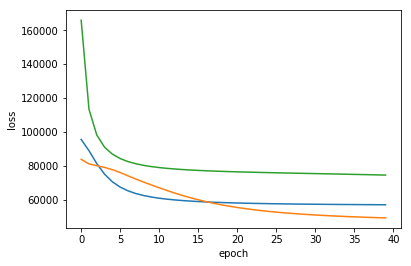

In [146]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

x = [i for i in range(num_epochs)]

for k, v in rate_loss.items():
    y = v
    plt.plot(x,y)
    
plt.xlabel('epoch')
plt.ylabel('loss')

# plt.show()